In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import json
import os
import pickle
import re

#from src.visualizations.additional_plotting_functions import loss_archetype_plot, NMI_archetypes, plot_NMI_stability

import matplotlib

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Plots for paper

In [31]:
my_pallette = {'RBOAA': "#EF476F", 'OAA': "#FFD166", 'AA': "#06D6A0","TSOAA" : "#073B4C","GT": "#9055A2"}

In [73]:


def load_result_obj(path: str):
    file = open(path,'rb')
    object_file = pickle.load(file)
    file.close()
    return object_file

def load_analyses(analysis_dir: str):
    """
    Function that loads results from a given analysis.
    The format is a nested dictionary on the form results[AA_method][n_archetypes][repetition_num]
    The result objects saved have all matrices and parameters inside them. E
    """

    folder = f'C:/Users/aejew/Downloads/SynthResults/{analysis_dir}'

    results = {'RBOAA': {}, 'OAA': {}, 'CAA': {}} if 'OSM' not in analysis_dir else {'TSAA': {}}



    for method in results.keys():
        method_dir = f'{folder}/{method}_objects'
        all_files = os.listdir(method_dir)
        for file in all_files:
            obj = load_result_obj(f'{method_dir}/{file}')
            K = re.sub('[^0-9]', '', file.split('_')[1])
            rep = int(file.split('_')[-1][-1])
            if f'K{K}' not in results[method].keys():
                results[method][f'K{K}'] = {}
            
            results[method][f'K{K}'][rep] = obj
    return results


# NAIVE DATA 

In [5]:
naive_res= load_analyses("1000_respondents_noRB_results")
naive_cor = load_analyses("1000_respondents_noRB_corrupted_results")
naive_osm = load_analyses("no_RB_OSM")
naive_osm_corr = load_analyses("no_RB_OSM_corrupted")

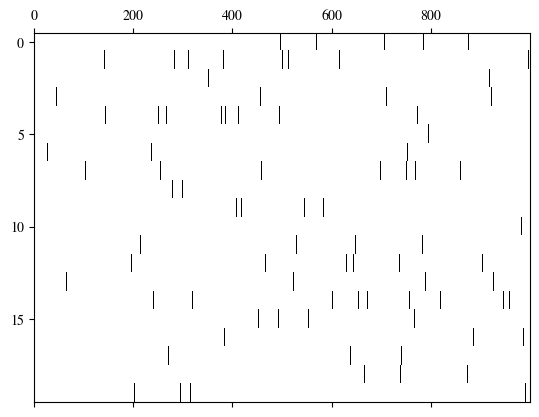

In [6]:
X = naive_res['RBOAA']['K1'][3].X
X_osm = naive_osm['TSAA']['K1'][3].X
X_cor = naive_cor['CAA']['K1'][3].X
plt.spy(X-X_cor, aspect = 'auto')

idx = np.nonzero(X-X_cor)

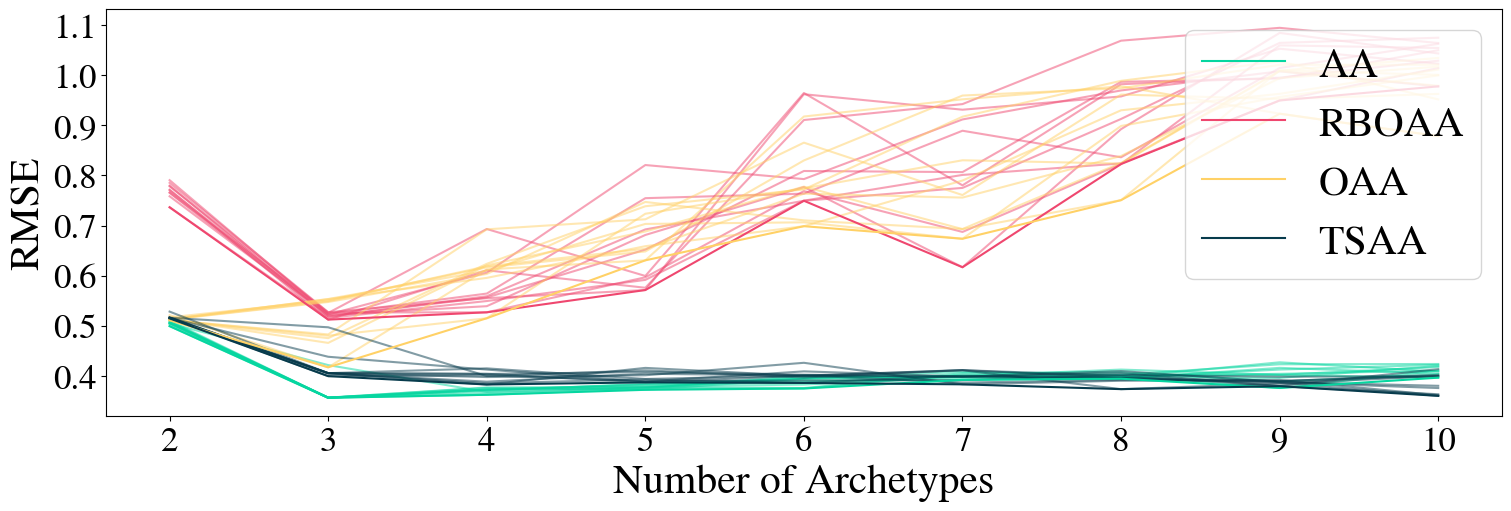

In [303]:
from src.visualizations.denoising import denoising

K_list = [2,3,4,5,6,7,8,9,10]
p = [1,2,3,4,5]
figName = 'test'
denoising(naive_res,naive_cor,naive_osm_corr,K_list,p,figName)

OAA[7 6 8 5 4 3 2 1 0]
[1.35590195e+04 1.14582275e+03 4.61255585e+02 6.13253937e+01
 1.15326672e+01 9.91346169e+00 8.48638535e+00 6.61419678e+00
 8.86780739e+00]
RBOAA[8 7 6 5 3 2 1 4 0]
[7.94289795e+03 6.10561594e-02 3.46076749e-02 2.19558403e-02
 2.32123062e-01 1.47002842e-02 3.64015927e-03 3.50795244e-03
 3.26500251e-03]
AA[8 7 6 5 4 3 2 1 0]
[4692.79248047 1531.26977539 1384.60168457 1289.39855957 1208.27368164
 1132.40063477 1070.24304199 1006.62683105  951.51281738]
TSAA[8 7 6 5 4 3 2 1 0]
[6453.3515625  2305.85644531 2034.07800293 1803.08703613 1594.36682129
 1439.21362305 1333.02844238 1253.30871582 1148.62023926]


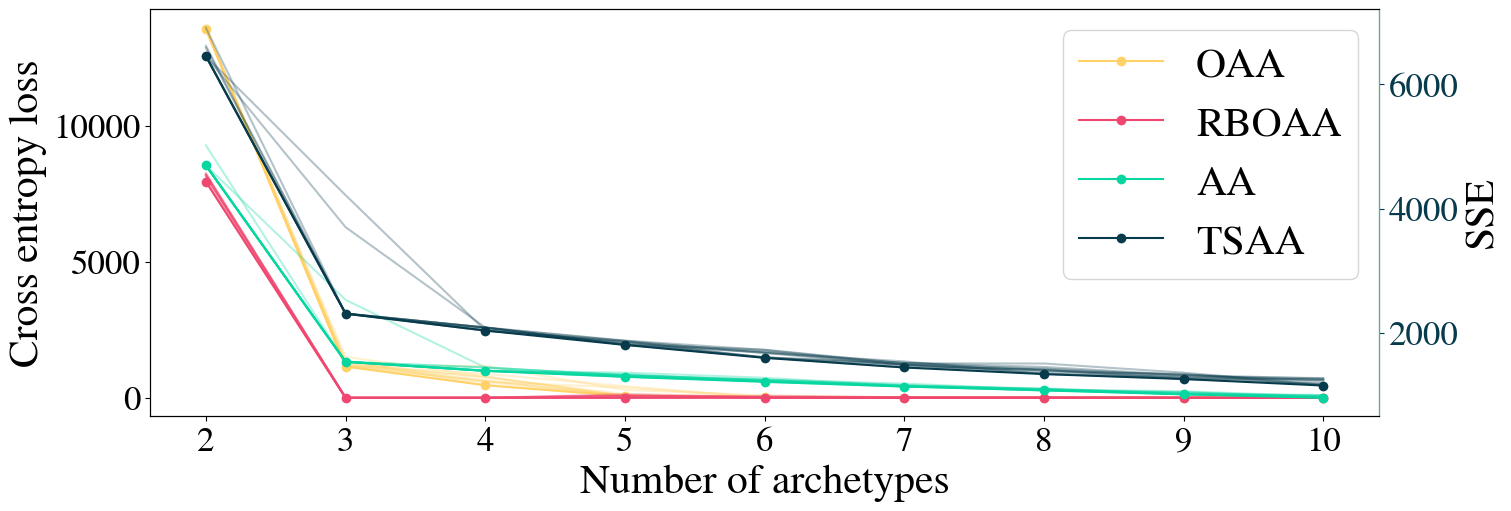

In [295]:
K_list = np.arange(2,11)
## Plot SSE
from src.visualizations. loss_archetype_plot import loss_archetype_plot

loss_archetype_plot(K_list,results_path = 'C:/Users/aejew/Downloads/AA_results/AA_results/1000_respondents_noRB_results/all_AA_results.json',results_path2 = 'C:/Users/aejew/Downloads/AA_results/AA_results/no_RB_OSM/all_AA_results.json')

plt.savefig("Plots_for_paper/Error_K_naive.png",dpi=1000)

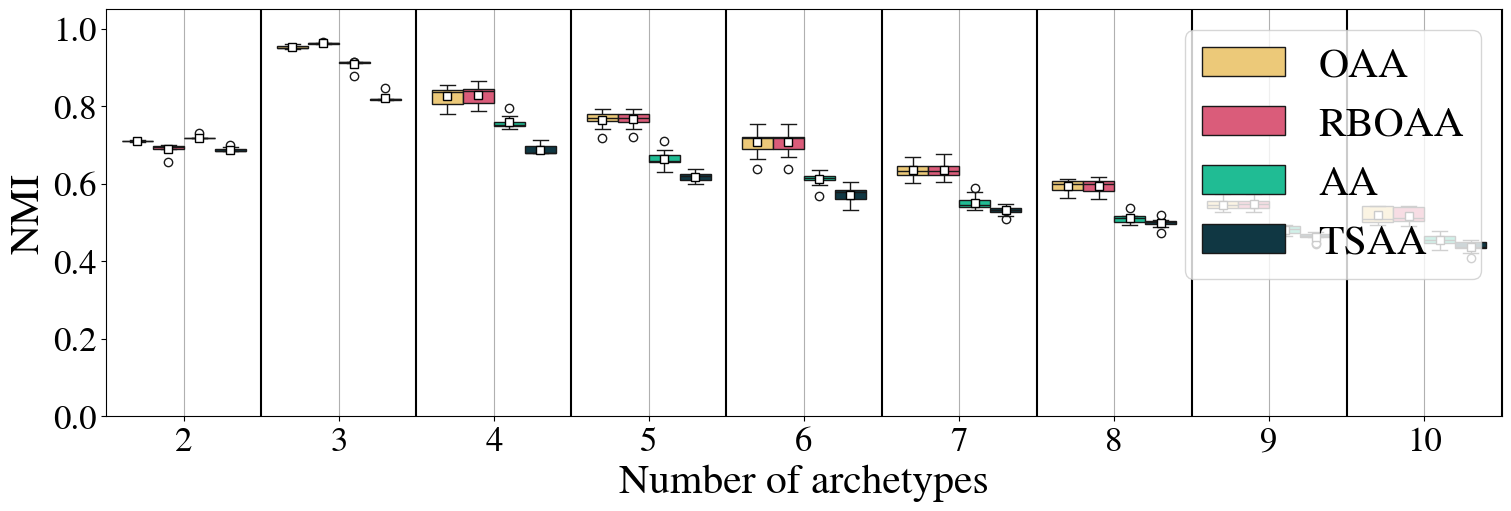

In [296]:
from src.visualizations. NMI_archetypes import NMI_archetypes

K_list = np.arange(2,11)
NMI_archetypes(K_list,results_path = 'C:/Users/aejew/Downloads/AA_results/AA_results/1000_respondents_noRB_results/all_AA_results.json',results_path2 = 'C:/Users/aejew/Downloads/AA_results/AA_results/no_RB_OSM/all_AA_results.json')

plt.savefig("Plots_for_paper/NMI_K_naive.png",dpi=1000)

# Complex Data

In [304]:
complex_res= load_analyses("complex_results")
complex_cor = load_analyses("complex_corrupted_results")
complex_osm = load_analyses("complex_OSM_results")
complex_osm_corr = load_analyses("complex_OSM_corrupted_results")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/Users/aejew/Downloads/SynthResults/complex_results/RBOAA_objects'

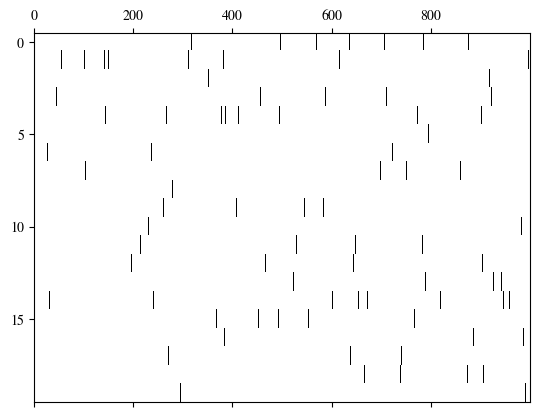

In [298]:
X = complex_res['RBOAA']['K1'][2].X
X_osm = complex_osm['TSAA']['K1'][3].X
X_cor = complex_cor['CAA']['K1'][3].X
plt.spy(X-X_cor, aspect = 'auto')

idx = np.nonzero(X-X_cor)



OAA[8 7 6 5 4 3 2 1 0]
[19904.61914062 15540.41992188 10807.14746094  7553.40625
  6802.43310547  5919.18066406  5281.10742188  4582.37011719
  3885.48632812]
RBOAA[8 7 6 5 4 2 1 3 0]
[6.07800928e+03 5.44738541e+01 5.86982727e-01 6.85633163e+01
 3.89244258e-01 3.58314008e-01 3.26829761e-01 2.81267047e-01
 2.45882362e-01]
AA[8 7 6 5 4 3 2 1 0]
[9575.61035156 6222.72070312 4178.64697266 2992.8684082  2700.76171875
 2404.86376953 2197.06274414 2057.43041992 1936.5760498 ]
TSAA[8 7 6 5 4 3 2 1 0]
[11261.23339844  7598.06591797  5262.81103516  3786.40039062
  3284.7668457   2955.49365234  2660.859375    2481.09179688
  2322.49462891]


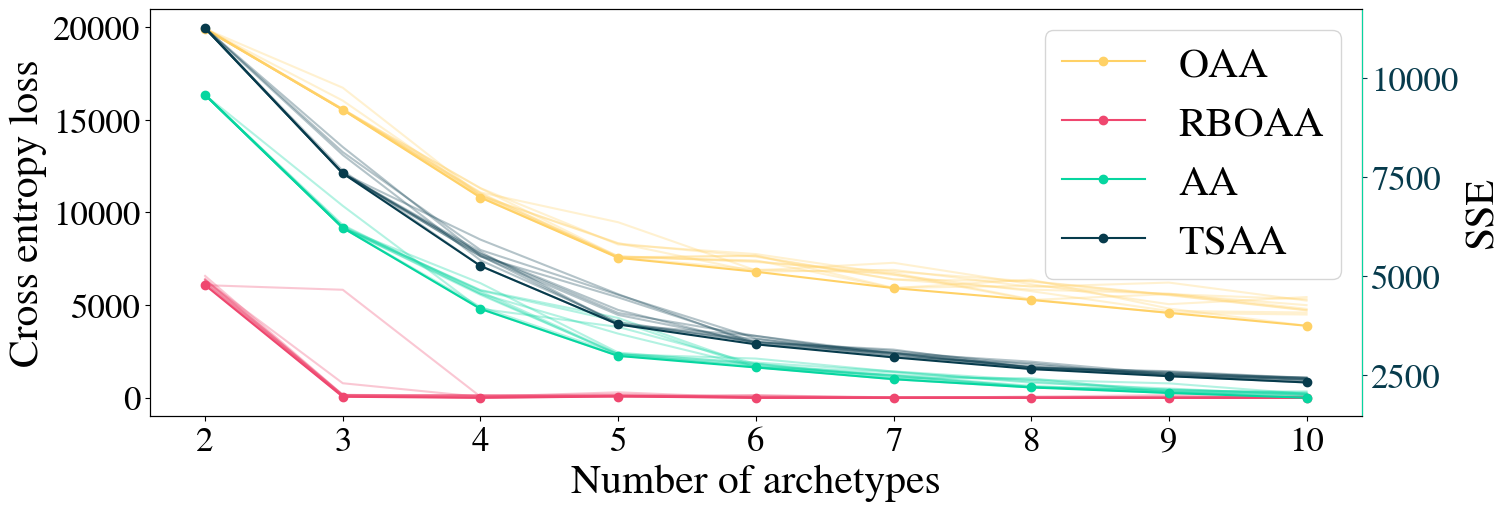

In [299]:
K_list = np.arange(2,11)
loss_archetype_plot(K_list,results_path = 'C:/Users/aejew/Downloads/AA_results/AA_results/complex_results/all_AA_results.json',results_path2 = 'C:/Users/aejew/Downloads/AA_results/AA_results/complex_OSM_results/all_AA_results.json')

plt.savefig("Plots_for_paper/Error_K_complex.png",dpi=1000)

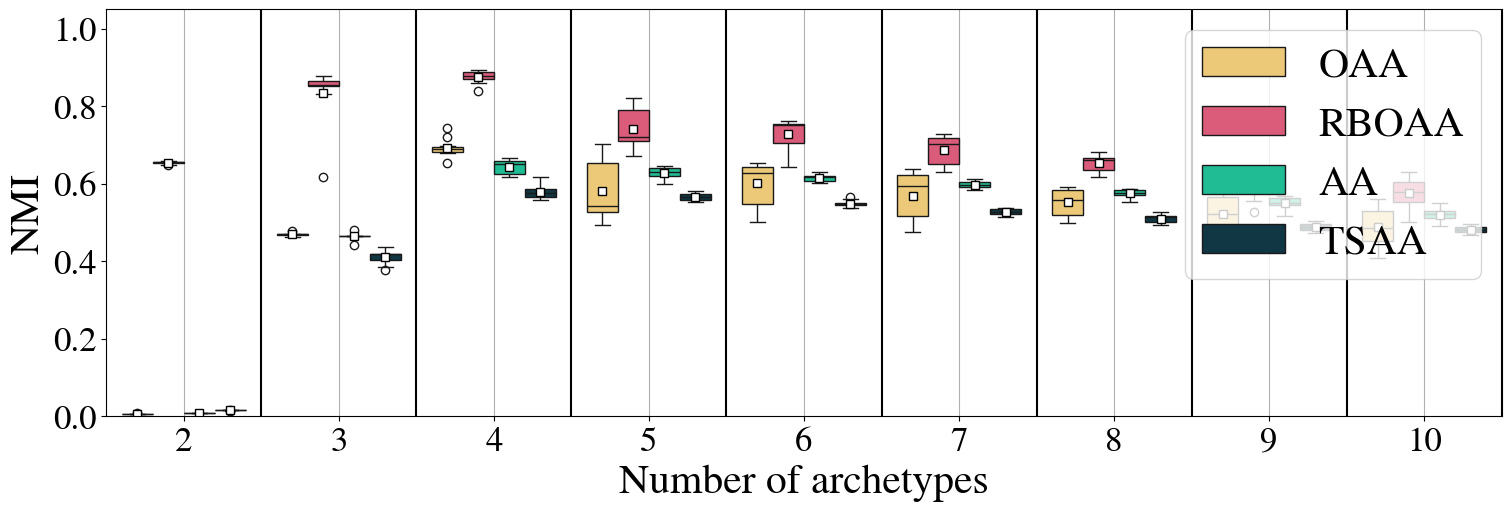

In [300]:
K_list = np.arange(2,11)
NMI_archetypes(K_list,results_path = 'C:/Users/aejew/Downloads/AA_results/AA_results/complex_results/all_AA_results.json',results_path2 = 'C:/Users/aejew/Downloads/AA_results/AA_results/complex_OSM_results/all_AA_results.json')

plt.savefig("Plots_for_paper/NMI_K_complex.png",dpi=1000)

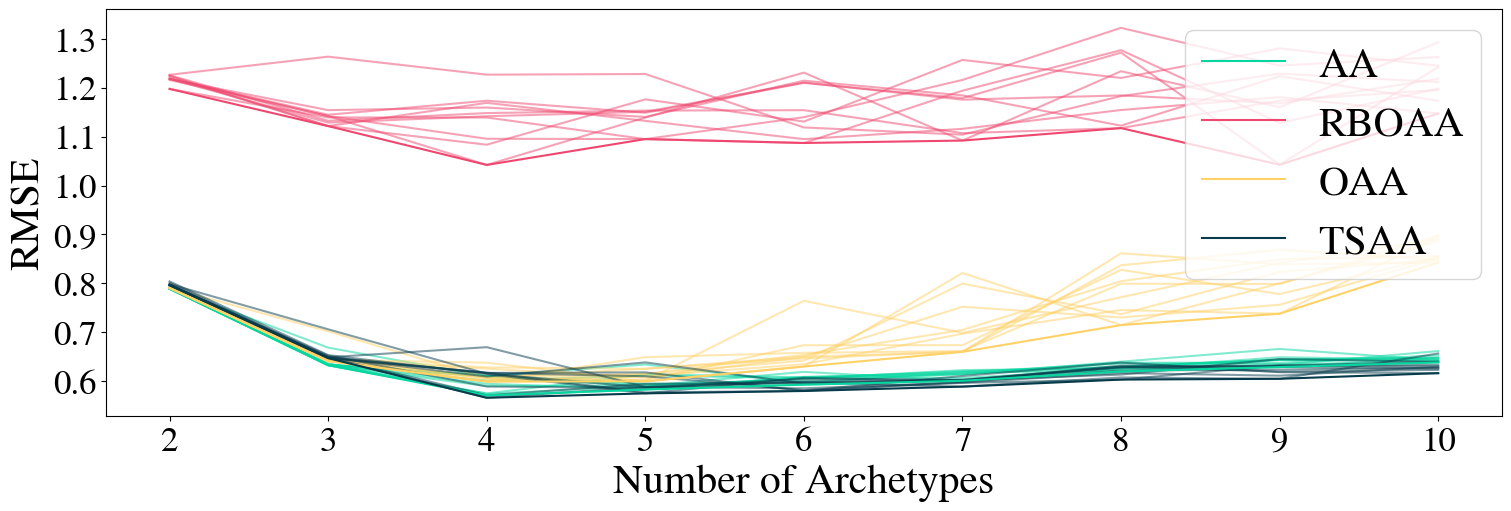

In [305]:
from src.visualizations.denoising import denoising
p = [1,2,3,4,5]
K_list = [2,3,4,5,6,7,8,9,10]


denoising(complex_res,complex_cor,complex_osm_corr,K_list,p,'test')


In [284]:
Q100_RB= load_analyses("RB_100Q_results")

Q20_RB = load_analyses("RB_20Q_results")



In [285]:
from src.utils.synthetic_data_class import _synthetic_data


SD = _synthetic_data(N=1000,M=20,K=3,p=5,sigma=-9.21,rb=True,a_param =1, b_param = 1.5,sigma_std = 1e-6)
#SD2 = _synthetic_Data(N=1000,M=20,K=3,p=5,sigma=-9.21,rb=True,a_param =1, b_param = 1.5,sigma_std = 1e-6)


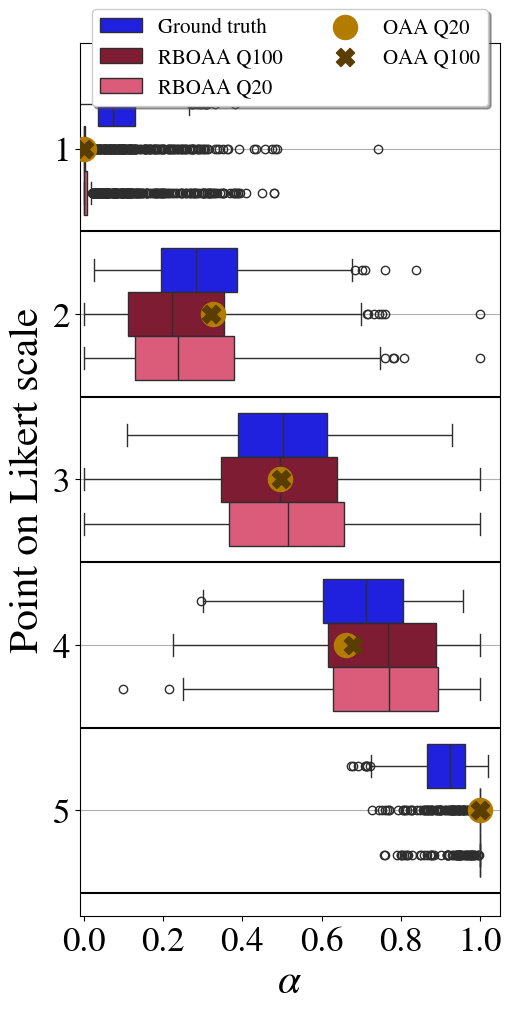

In [286]:
#from src.visualizations.response_bias import response_bias_plot
from src.visualizations.response_bias import response_bias_plot  

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'




RBOAA_betasQ100 = Q100_RB['RBOAA']['K3'][2].b
OAA_betasQ100 = Q100_RB['OAA']['K3'][2].b

RBOAA_betasQ20 = Q20_RB['RBOAA']['K3'][2].b
OAA_betasQ20 = Q20_RB['OAA']['K3'][2].b

response_bias_plot(X,  RBOAA_betasQ20, OAA_betasQ20,RBOAA_betasQ100, OAA_betasQ100 ,6, 'RB_synth', synthetic_betas=SD.betas)

#response_bias_plot(X, RBOAA_betas, OAA_betas,6,'RB_GB', synthetic_betas=SD.betas)

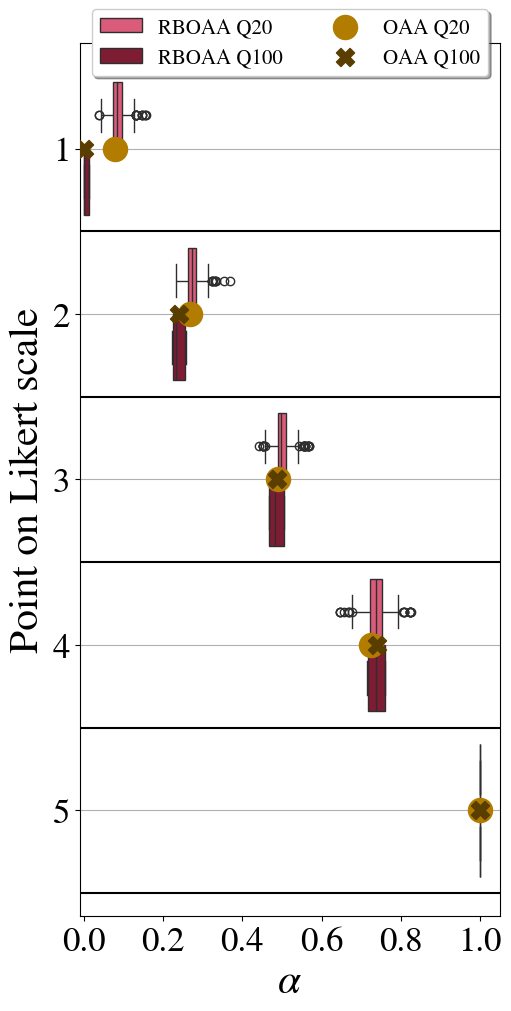

In [287]:
Q100_NoRB = load_analyses("noRB_100Q_results")
Q20_NoRB = load_analyses("noRB_20Q_results")



RBOAA_betasQ100 = Q100_NoRB['RBOAA']['K3'][2].b
OAA_betasQ100 = Q100_NoRB['OAA']['K3'][2].b

RBOAA_betasQ20 = Q20_NoRB['RBOAA']['K3'][2].b
OAA_betasQ20 = Q20_NoRB['OAA']['K3'][2].b



response_bias_plot(X,  RBOAA_betasQ20, OAA_betasQ20,RBOAA_betasQ100, OAA_betasQ100 ,6, 'noRB_synth', synthetic_betas=None)

